In [2]:
import random
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from time import time
from QAP_Heuristic import QAP_Heuristic

In [3]:
def randomized_greedy_qap(distance_matrix, flow_matrix, p=0.1):
    num_facilities = distance_matrix.shape[0]
    
    unassigned = set(range(num_facilities))
    assignment = [-1] * num_facilities

    while unassigned:
        min_cost = float('inf')
        selected_pair = (None, None)

        # Consider all pairs (i, j) where i is an unassigned facility and j is a location
        candidates = []
        for i in unassigned:
            for j in range(num_facilities):
                if assignment[j] == -1:  # check if location j is unassigned
                    cost = sum(flow_matrix[i][k] * distance_matrix[j][assignment[k]] for k in range(num_facilities) if assignment[k] != -1)
                    if cost < min_cost:
                        min_cost = cost
                        selected_pair = (i, j)
                        candidates = [(i, j)]
                    elif cost == min_cost:
                        candidates.append((i, j))
        
        # Select a random pair from the top p fraction of candidates
        num_candidates_to_consider = int(p * len(candidates))
        if num_candidates_to_consider < 1:
            num_candidates_to_consider = 1
        i, j = candidates[np.random.choice(num_candidates_to_consider)]

        # Assign facility i to location j
        assignment[j] = i
        unassigned.remove(i)

    return assignment

In [13]:
class RandomizedGreedy(QAP_Heuristic):
    def __init__(self, w, d, probability) -> None:
        super().__init__(w, d)
        self.probability = probability

    def __str__(self) -> str:
        return "RandomizedGreedy"

    def solve(self, n_iters):
        """
        generates greedy assignments for 60 seconds, returning the argmin wrt cost function
        in the event that no assignments are generated in 60 seconds, the algorithm returns a random permutation
        """
        assignments = []
        
        for _ in range(n_iters):

            if time() > self.MAX_CPU_TIME: break

            unassigned = set(range(self.n))
            assignment = [-1] * self.n

            while unassigned:
                
                if time() > self.MAX_CPU_TIME: break
                
                min_cost = float('inf')

                # Consider all pairs (i, j) where i is an unassigned facility and j is a location
                candidates = []
                for i in unassigned:
                    for j in range(self.n):
                        if assignment[j] == -1:  # check if location j is unassigned
                            cost = sum(self.W[i][k] * self.D[j][assignment[k]] for k in range(self.n) if assignment[k] != -1)
                            if cost < min_cost:
                                min_cost = cost
                                candidates = [(i, j)]
                            elif cost == min_cost:
                                candidates.append((i, j))
                
                # Select a random pair from the top p fraction of candidates
                num_candidates_to_consider = int(self.probability * len(candidates))
                if num_candidates_to_consider < 1:
                    num_candidates_to_consider = 1
                i, j = candidates[np.random.choice(num_candidates_to_consider)]

                # Assign facility i to location j
                assignment[j] = i
                unassigned.remove(i)
            
            assignments.append(assignment)
        
        return min(assignments, key=self.cost) if len(assignments) > 0 else np.random.permutation(self.n)

In [14]:
def sol_cost(solution, distance_matrix, flow_matrix):
    cost = 0
    num_facilities = len(solution)
    for i in range(num_facilities):
        for j in range(num_facilities):
            cost += distance_matrix[i][j] * flow_matrix[solution[i]][solution[j]]
    return cost

In [15]:

def visualize_qap_solution(distance_matrix, flow_matrix, solution):
    num_facilities = distance_matrix.shape[0]
    cost_matrix = np.zeros((num_facilities, num_facilities))

    for i in range(num_facilities):
        for j in range(num_facilities):
            cost_matrix[i][j] = distance_matrix[i][j] * flow_matrix[solution[i]][solution[j]]

    plt.matshow(cost_matrix, cmap='viridis')
    plt.colorbar(label='Cost')
    plt.title('Cost for each Facility-Location Mapping')
    plt.xlabel('Facilities')
    plt.ylabel('Locations')
    plt.show()

In [16]:
# set up params for plots
SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=SMALL)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=SMALL)       # controls default text sizes

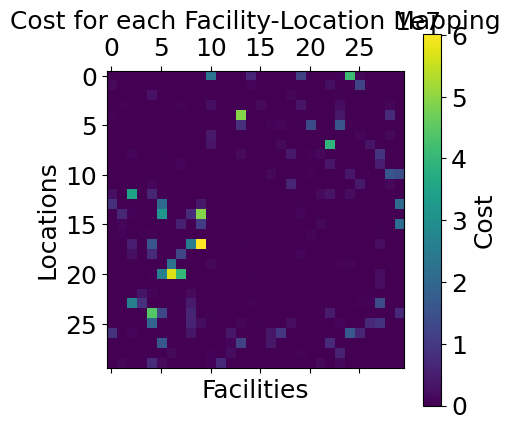

[10, 4, 14, 6, 29, 8, 22, 17, 1, 23, 7, 12, 16, 27, 9, 15, 24, 21, 11, 28, 26, 0, 20, 5, 19, 18, 3, 25, 13, 2]
1194853253


In [17]:
# for managing file opening and closing
def read_integers(filename):
    with open(filename) as f:
        return [int(elem) for elem in f.read().split()]

# Using raw string for the path
file_path = '../QAPInstances/tai30b.dat'  # Change 'tai30b.dat' to your actual file name
file_it = iter(read_integers(file_path))

# Number of points
n = next(file_it)

# Distance between locations
w = np.array([[next(file_it) for j in range(n)] for i in range(n)])
d = np.array([[next(file_it) for j in range(n)] for i in range(n)])

solution = randomized_greedy_qap(w, d)
cost = sol_cost(solution,w,d)
visualize_qap_solution(w, d, solution)
print(solution)
print(cost)

### Automated Testing

In [21]:
import csv


instance_path = '../QAPInstances/'
soln_path     = '../QAPSolns/'

def open_solution(filename: str):
    file_it = iter(read_integers(filename))
    _ = next(file_it)    # this is just how the files within the lib are formatted
    return next(file_it)

        

def test_hueristic(n_iters=10_000, tai_only=False):
    
    

    with open('../results/RandomisedGreedy', mode='w') as f: 

        writer = csv.writer(f)

        for filename in os.listdir(instance_path):
            

            if tai_only and 'tai' not in filename: continue

            file_it = iter(read_integers(instance_path+filename))

            # open QAP instance param's 
            n = next(file_it)
            w = np.array([[next(file_it) for j in range(n)] for i in range(n)])
            d = np.array([[next(file_it) for j in range(n)] for i in range(n)])

            # generate an instance
            rg = RandomizedGreedy(w,d,probability=0.01)

            # open up corresponding soln from QAPLib: 
            soln_file = filename[:-4]+'.sln' # this removes the .dat from filename
            
            try:
                qap_soln = open_solution(soln_path+soln_file)
                huerstic_soln = rg.solve(n_iters)

                # compute gap
                gap = 100*(rg.cost(huerstic_soln) - qap_soln)/qap_soln
                print(filename, gap)
                writer.writerow([filename, gap])

            # any instances without corresponding solution files are deleted
            except FileNotFoundError:
                os.remove(instance_path+filename) 

    return 

In [22]:
test_hueristic(100_000, tai_only=True)